In [1]:
# Column Description
# Column 0	Mov_dtservidor	Server Date 
# Column 1	Mov_dtavl	AVL Date
# Column 2	Mov_Idlinha --> Line Code
# Column 3	Mov_longitude	 Longitude
# Column 4	Mov_latitude	 Latitude
# Column 5	Mov_Idavl	 AVL Code (table av)
# Column 6	Mov_Evento	Trip event (0=open 64=closed)
# Column 7	Mov_Idponto	point (gtfs information)

In [1]:
import pandas as pd

In [2]:
import pyspark

conf = pyspark.SparkConf()
conf = (conf.setMaster("local[*]")
        .set('spark.executor.memory', "64G")\
        .set('spark.driver.memory', "64G")\
        .set('spark.default.parallelism', '128') \
        .set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3,com.databricks:spark-xml_2.11:0.6.0'))

sparkContext = pyspark.SparkContext(conf=conf)
sparkSession = pyspark.sql.SparkSession(sparkContext)

AWS_ACCESS_KEY_ID='your_key'

AWS_SECRET_ACCESS_KEY='your_key'

hadoop_conf = sparkSession._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.access.key", AWS_ACCESS_KEY_ID)
hadoop_conf.set("fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY)
hadoop_conf.set("fs.s3a.connection.maximum", "100")

In [11]:
df = sparkSession.read.option("header", "false").csv('s3a://mobility-traces-bus-sp/MO_15104.csv')

In [12]:
column_names = "dtservidor,dtavl,idlinha,latitude,longitude,idavl,evento,idponto".split(",")

for i in range(len(column_names)):
    df = df.withColumnRenamed("_c%s" % i, column_names[i])

In [4]:
df.show()

+--------------------+--------------------+-------+----------+----------+-----+------+-------+
|          dtservidor|               dtavl|idlinha|  latitude| longitude|idavl|evento|idponto|
+--------------------+--------------------+-------+----------+----------+-----+------+-------+
|2015-10-01 04:00:...|2015-10-01 03:59:...|   1038|-23.562598|-46.445810|43169|    64|   7823|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  33093|-23.579135|-46.481513|57458|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  34233|-23.767883|-46.716332|11109|     0|   7774|
|2015-10-01 04:00:...|2015-10-01 03:59:...|    898|-23.507058|-46.400353|42695|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|   2036|-23.738058|-46.697865|13878|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|   1816|-23.448900|-46.599482|44684|    64|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  33486|-23.552840|-46.557060|51994|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:57:...|   1044

In [10]:
from dateutil import parser
from pyspark.sql.functions import *# udf, struct, col, countDistinct
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, BooleanType

def get_hour(row):
    date = parser.parse(row)
    return date.hour

def get_open(row):
    if len(row) != 0:
        middle = int(len(row)/2)
        return int(row[middle]) == 0
    else:
        return False

udf_get_hour = udf(get_hour, IntegerType())
udf_get_open = udf(get_open, BooleanType())

In [17]:
df.groupBy("idlinha").count().show()

+-------+-----+
|Idlinha|count|
+-------+-----+
|   2088|16247|
|    691|11455|
|    829|23826|
|    675|28460|
|  32773| 5563|
|  35004| 4056|
|   2069| 9736|
|   2136|22023|
|   2162| 4805|
|   1159| 1855|
|  33783| 7016|
|  33665|10966|
|   2294|  313|
|  34657| 3016|
|  33174|12583|
|  32939|29329|
|    125|33374|
|    800|16262|
|  33615|13753|
|   1372|13846|
+-------+-----+
only showing top 20 rows



In [13]:
df.select("idavl").distinct().count()

14392

In [14]:
!unzip DISTRITO_MUNICIPAL_SP_SMDU

Archive:  DISTRITO_MUNICIPAL_SP_SMDU.zip
replace DISTRITO_MUNICIPAL_SP_SMDUPolygon.cst? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [15]:
import geopandas as gpd

sp = gpd.read_file("DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")

In [ ]:
sp.plot()

In [17]:
sp.head()

,Codigo,Nome,geometry
0,51,MANDAQUI,"POLYGON ((-46.65470 -23.43063, -46.65468 -23.4..."
1,52,MARSILAC,"POLYGON ((-46.60987 -23.90550, -46.60990 -23.9..."
2,32,MOEMA,"POLYGON ((-46.65361 -23.57219, -46.65359 -23.5..."
3,57,PARQUE DO CARMO,"POLYGON ((-46.44461 -23.59272, -46.44470 -23.5..."
4,60,PERDIZES,"POLYGON ((-46.66355 -23.53692, -46.66362 -23.5..."


In [18]:
len(sp)

96

In [19]:
from shapely.geometry import Point, Polygon

def get_region(row, sp):
    point = Point((float(row[0]), float(row[1])))
    for i in range(96):
        if point.within(sp.loc[i, "geometry"]):
            return sp.loc[i, "Nome"]
    return "Fora"

def get_region_udf(sp):
    return udf(lambda x: get_region(x, sp))

In [20]:
df = df.withColumn("hour", udf_get_hour(df["dtavl"]))

df_new = df.withColumn("bairro", get_region_udf(sparkContext.broadcast(sp).value)
                                                           (struct(df["longitude"],
                                                             df["latitude"])))

In [22]:
df_regions = df_new.groupBy("hour", "bairro").agg(countDistinct("idavl").alias("count")).toPandas()

In [23]:
df_regions.sort_values("count", ascending = False).head()

,hour,bairro,count
698,7,JARDIM SAO LUIS,1054
945,6,JARDIM SAO LUIS,1054
25,9,JARDIM SAO LUIS,1047
530,8,JARDIM SAO LUIS,1047
76,10,JARDIM SAO LUIS,1046


In [24]:
df_final = pd.merge(df_regions, sp, left_on = "bairro", right_on = "Nome").drop(columns = ["Nome"])

In [25]:
geo_df = gpd.GeoDataFrame(df_final, geometry = "geometry")
geo_df.head()

,hour,bairro,count,Codigo,geometry
0,4,JOSE BONIFACIO,768,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
1,10,JOSE BONIFACIO,699,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
2,7,JOSE BONIFACIO,696,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
3,21,JOSE BONIFACIO,706,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
4,6,JOSE BONIFACIO,728,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."


Hora:  0


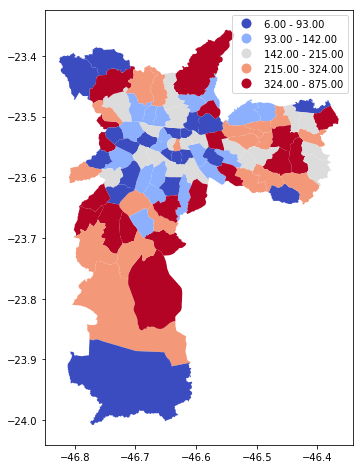

Hora:  1


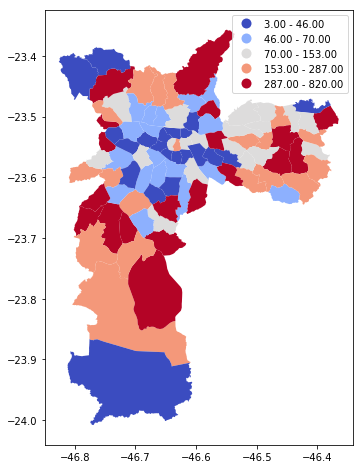

Hora:  2


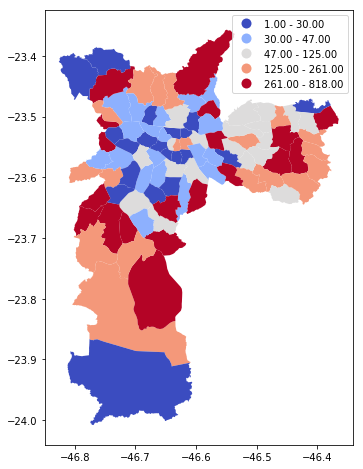

Hora:  3


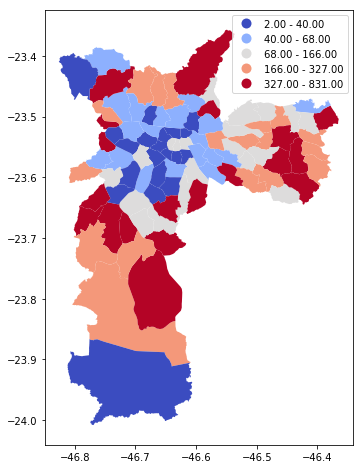

Hora:  4


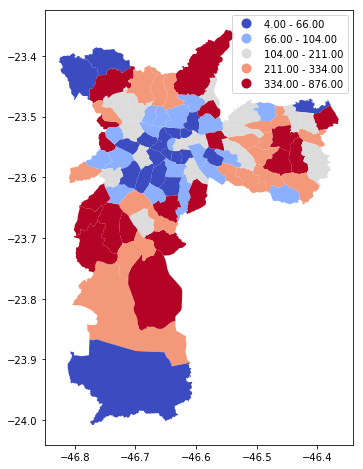

Hora:  5


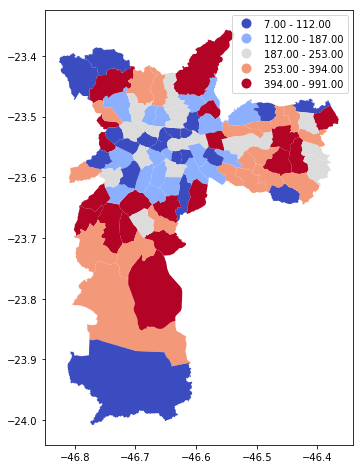

Hora:  6


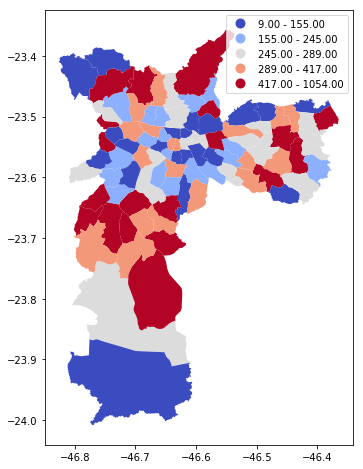

Hora:  7


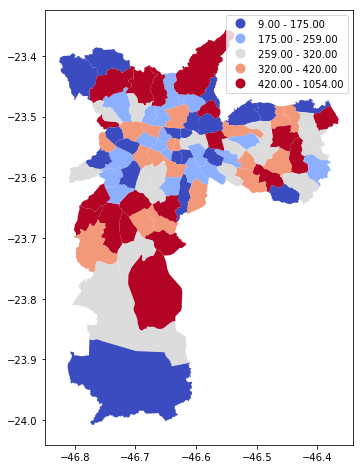

Hora:  8


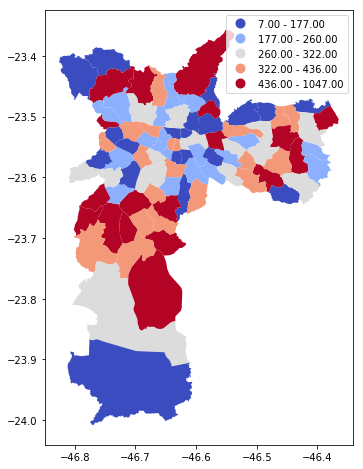

Hora:  9


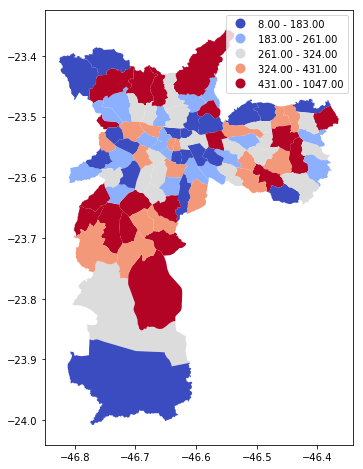

Hora:  10


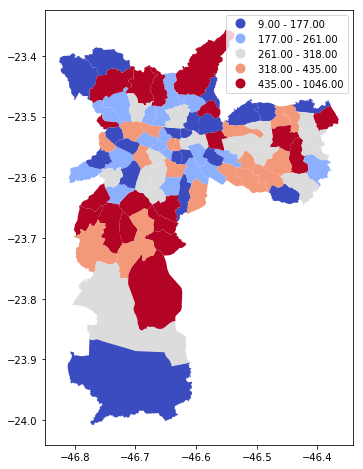

Hora:  11


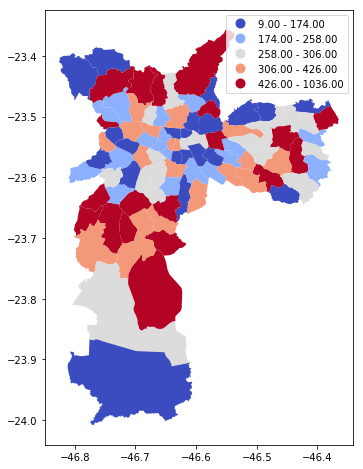

Hora:  12


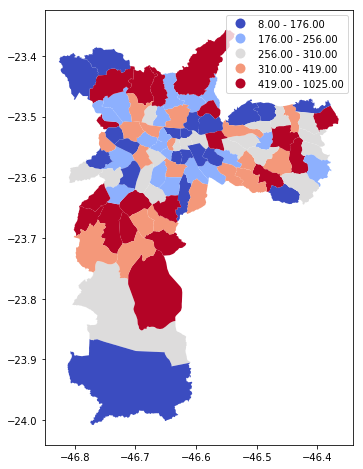

Hora:  13


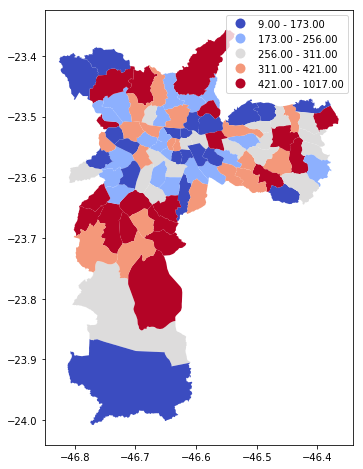

Hora:  14


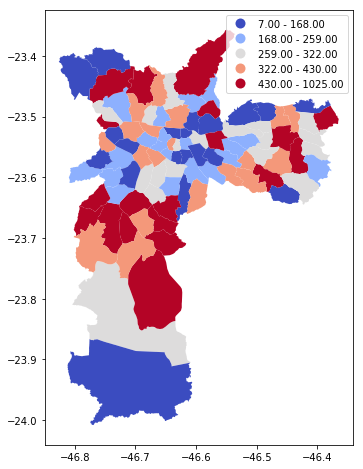

Hora:  15


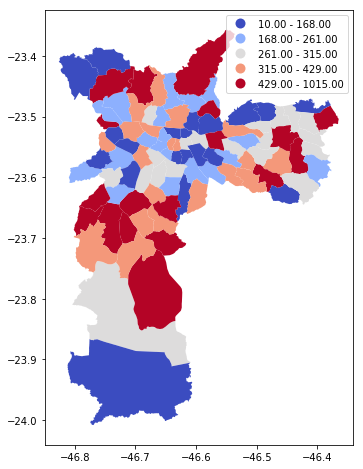

Hora:  16


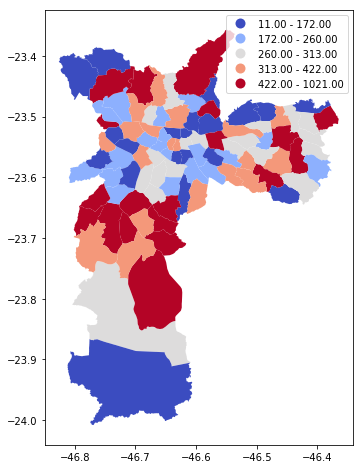

Hora:  17


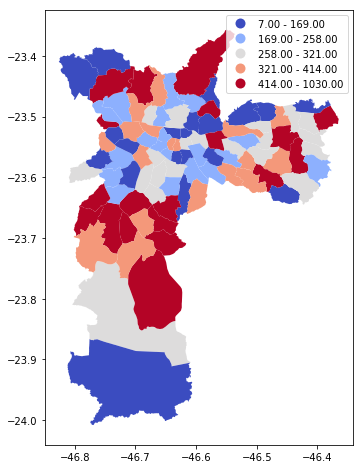

Hora:  18


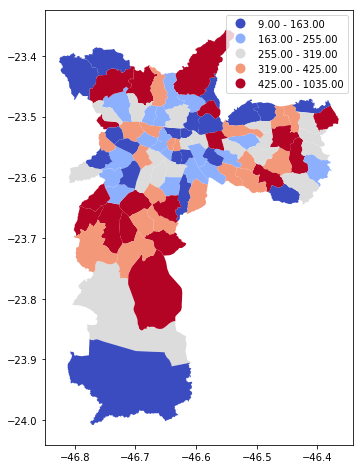

Hora:  19


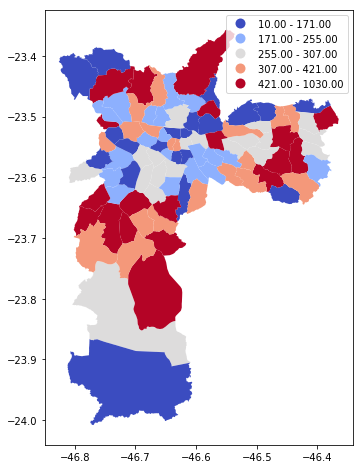

Hora:  20


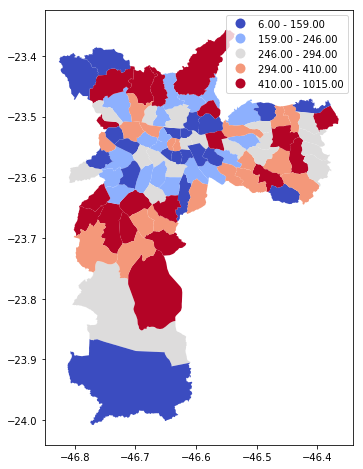

Hora:  21


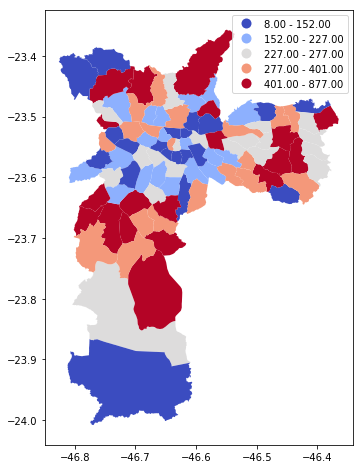

Hora:  22


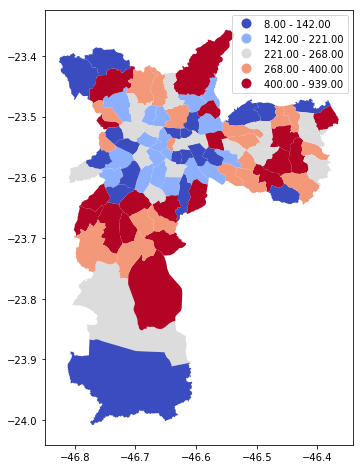

Hora:  23


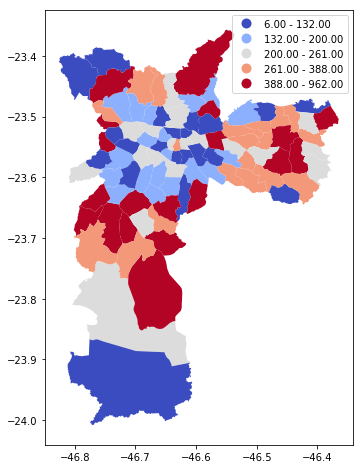

In [26]:
#color maps https://matplotlib.org/tutorials/colors/colormaps.html

import matplotlib.pyplot as plt

for hour in range(24):
    print("Hora: ", hour)
    geo_df[geo_df["hour"] == hour].plot(column = "count",legend = True,  cmap='coolwarm', figsize = (8,8),scheme='quantiles' )
    plt.show()

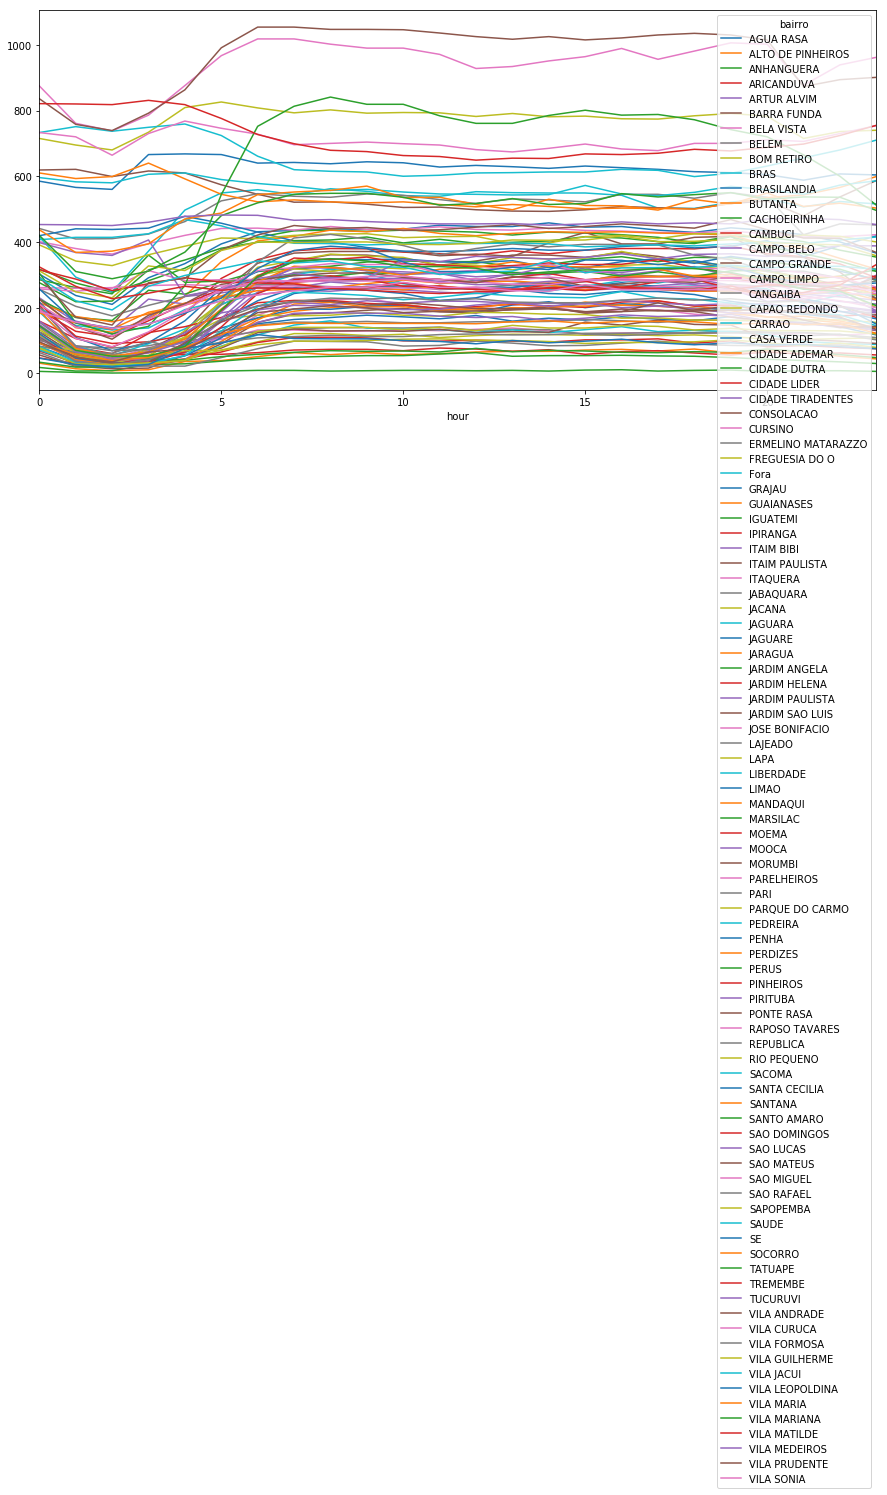

In [27]:
df_regions.pivot_table(index=df_regions['hour'],columns='bairro',values='count').plot(figsize=(15,7), kind = "line")

In [ ]:
# !pip install mapclassify